# Predicting Solar Panel Adoption - Random Forest Two-Stage Model
#### UC Berkeley MIDS
`Team: Gabriel Hudson, Noah Levy, Laura Williams`

Using the dataset defined in the Data Set Up notebook, train two Random Forest sequential models:
* Random Forest Classifier to predict presence or absence of solar panels  
* Random Forest Regressor to predict solar panel density and analyize most important predictive features.

In [1]:
# imports
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import rfpimp as rfp

%matplotlib inline

In [2]:
# if necessary, install package for calculating feature importances
#!pip install rfpimp

In [3]:
# load curated dataset
deepsolar = pd.read_csv('../Datasets/SolarPrediction_Final_Dataset.csv', index_col=0)

In [4]:
print("Dataset rows and dimensions:", deepsolar.shape)

Dataset rows and dimensions: (71305, 59)


## Pre-process data

* Define outcome variables
* Split into test/train/dev

In [5]:
#outcome_var = 'number_of_solar_system_per_household'
primary_outcome_variable = 'owner_occupied_solar_system_density'

In [6]:
# create binary outcome variable for stage 1 RF classifier
deepsolar['solar_flag']=deepsolar[primary_outcome_variable].apply(lambda x: int(x>0))

In [7]:
# Confirm values in new outcome variable
print("New binary outcome variable for Stage 1 random forest classifier 'solar_flag' has", 
      deepsolar['solar_flag'].nunique(), "values:", deepsolar["solar_flag"].min(),
      "and", deepsolar["solar_flag"].max())

New binary outcome variable for Stage 1 random forest classifier 'solar_flag' has 2 values: 0 and 1


Split data into test, training and development sets. Test data will not be used until model and dataset has been optimized on the training and development datasets.

In [8]:
# separate outcome variables and features
X = deepsolar.drop(labels=['solar_flag', primary_outcome_variable], axis=1).values
Y_classifier = deepsolar['solar_flag'].values
Y_regressor = deepsolar[primary_outcome_variable].values
print("Full featureset shape is", X.shape)
print("Classifier outcome variable shape:", Y_classifier.shape)
print("Regressor outcome variable shape:", Y_regressor.shape)

Full featureset shape is (71305, 58)
Classifier outcome variable shape: (71305,)
Regressor outcome variable shape: (71305,)


In [9]:
# split into 80% training and 20% test set, using random shuffle
# Keep random seed at 0 so the final test set is always the same
X_train, X_test, Y_classifier_train,  Y_classifier_test, \
Y_regressor_train, Y_regressor_test = train_test_split(X, Y_classifier, Y_regressor, 
                                                       test_size=0.2, random_state=0, shuffle=True)

In [10]:
print("{:<35}\t{}".format("Training data shape:", X_train.shape))
print("{:<35}\t{}".format("Training outcome variable - classifier:",Y_classifier_train.shape ))
print("{:<35}\t{}".format("Training outcome variable - regressor:",Y_regressor_train.shape ))
print("{:<35}\t{}".format("Test data shape:", X_test.shape))
print("{:<35}\t{}".format("Test outcome variable - classifier:",Y_classifier_test.shape ))
print("{:<35}\t{}".format("Test outcome variable - regressor:",Y_regressor_test.shape ))

Training data shape:               	(57044, 58)
Training outcome variable - classifier:	(57044,)
Training outcome variable - regressor:	(57044,)
Test data shape:                   	(14261, 58)
Test outcome variable - classifier:	(14261,)
Test outcome variable - regressor: 	(14261,)


If not using cross-validation, create another training and development set from the 80% training set.

If using cross-validation, skip ahead to the **Train the model using cross-validation** section.

In [28]:
X_train2, X_dev, \
Y_classifier_train2,  Y_classifier_dev,  \
Y_regressor_train2, Y_regressor_dev = train_test_split(X_train, Y_classifier_train, Y_regressor_train, 
                                                       test_size=0.2, random_state=None, shuffle=True)

In [12]:
# If create training/development subset:
print("Training subset and development set created from 80% training set:")
print("{:<40}\t{}".format("Training subset data shape:", X_train2.shape))
print("{:<40}\t{}".format("Training subset outcome variable - classifier:",Y_classifier_train2.shape ))
print("{:<40}\t{}".format("Training subset outcome variable - regressor:",Y_regressor_train2.shape ))
print("{:<40}\t{}".format("Dev data shape:", X_dev.shape))
print("{:<40}\t{}".format("Dev outcome variable - classifier:",Y_classifier_dev.shape ))
print("{:<40}\t{}".format("Dev outcome variable - regressor:",Y_regressor_dev.shape ))


Training subset and development set created from 80% training set:
Training subset data shape:        	(45635, 105)
Training subset outcome variable - classifier:	(45635,)
Training subset outcome variable - regressor:	(45635,)
Dev data shape:                    	(11409, 105)
Dev outcome variable - classifier: 	(11409,)
Dev outcome variable - regressor:  	(11409,)


## Train the model  - no cross-validation
This section uses only a single training/develpment data split from the 80% training data

In [13]:
def train_2stage_model(n, depth, features, 
                       n_R, depth_R, features_R,
                       X_train, Y_classifier_train, Y_regressor_train,
                       X_test, Y_classifier_test, Y_regressor_test):
    """Input: hyperparameters for Stage 1 classifier, hyperparameters for Stage 2 regressor,
    training and test data, and training and test outcome variables for both the
    classifier and regressor.
    Output: classifer model and R squared score, regressor model and R squared score, 
    combined model R squared score
    NOTE: this function takes only one training set and one test set, no cross-validation"""
    # define and fit classifier
    classifier = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
    classifier.fit(X_train, Y_classifier_train)  
    # define and fit regressor
    regressor = RandomForestRegressor(n_estimators=n_R, max_depth=depth_R, max_features=features_R, n_jobs=1)
    regressor.fit(X_train, Y_regressor_train)
    # calculate individual scores
    classifier_score = classifier.score(X_test,Y_classifier_test)
    regressor_score = regressor.score(X_test,Y_regressor_test)
    # calculate combined model scores
    classifier_preds=classifier.predict(X_test)
    regressor_preds=regressor.predict(X_test)
    final_preds=regressor_preds*classifier_preds
    combined_score = r2_score(Y_regressor_test,final_preds)
    
    return classifier, regressor, classifier_score, regressor_score, combined_score
    

In [12]:
# Classifier parameters
n = 100
depth = None
features = 'auto'

In [13]:
# Regressor parameters
n_R = 100
depth_R = 15
features_R = 'auto'

In [29]:
# train the full model and report scores using training set and development set
start = time.time()
classifier, \
regressor, \
classifier_score, \
regressor_score, \
combined_score = train_2stage_model(n, depth, features, 
                                    n_R, depth_R, features_R,
                                    X_train2, Y_classifier_train2, Y_regressor_train2,
                                    X_dev, Y_classifier_dev, Y_regressor_dev)
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Processing time: 6.35 minutes


In [49]:
# base dataset (see Data Set Up notebook) - original NOT cross-validated
print("Individual classifier R squared is:", classifier_score)
print("Individual regressor R squared is:", regressor_score)
print("Combined final model R squared is:", combined_score)

Individual classifier R squared is: 0.806819177842
Individual regressor R squared is: 0.745984529397
Combined final model R squared is: 0.747825123116


In [67]:
# train the full model and report scores using training set and development set - no geographic features
start = time.time()
classifier_nogeo, \
regressor_nogeo, \
classifier_score_nogeo, \
regressor_score_nogeo, \
combined_score_nogeo = train_2stage_model(n, depth, features, 
                                    n_R, depth_R, features_R,
                                    X_train, Y_classifier_train, Y_regressor_train,
                                    X_dev, Y_classifier_dev, Y_regressor_dev)
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Processing time: 4.2 minutes


In [68]:
# geographic variables removed - NOT cross-validated
print("Individual classifier R squared is:", classifier_score_nogeo)
print("Individual regressor R squared is:", regressor_score_nogeo)
print("Combined final model R squared is:", combined_score_nogeo)

Individual classifier R squared is: 0.800596020685
Individual regressor R squared is: 0.714618183312
Combined final model R squared is: 0.715420251887


## Train the model using cross-validation

Set up data splits from the 80% training set for cross-validation testing of models. Use 3 splits with smaller n-estimator hyperparameter for more quickly testing different datasets, use 10 splits for final dataset testing and reporting.

In [68]:
# set up number of splits
n_splits = 10
# Set random state for testing different datasets against each other, set to None for final testing
random_state = None

In [69]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
X_trains=[]
X_devs=[]
Y_classifier_trains=[]
Y_classifier_devs=[]
Y_regressor_trains=[]
Y_regressor_devs=[]

for train_index, test_index in kf.split(X_train):
    X_trains.append(X_train[train_index])
    X_devs.append(X_train[test_index])
    Y_classifier_trains.append(Y_classifier_train[train_index])
    Y_classifier_devs.append(Y_classifier_train[test_index])
    Y_regressor_trains.append(Y_regressor_train[train_index])
    Y_regressor_devs.append(Y_regressor_train[test_index])

In [70]:
print("Confirm there are the correct number of splits in each training/dev set:")
print(len(X_trains), len(X_devs), len(Y_classifier_trains), len(Y_classifier_devs), 
      len(Y_regressor_trains), len(Y_regressor_devs))
print("Full training dataset size:", X_train.shape, "Full testing dataset size:")
print("Check shape of data subsets:")
print("Training set size:", X_trains[0].shape)
print("Test set size:", X_devs[0].shape)
print("Classifier outcome train size:", Y_classifier_trains[0].shape)
print("Regressor outcome train size:", Y_regressor_trains[0].shape)
print("Classifier outcome test size:", Y_classifier_devs[0].shape) 
print("Regressor outcome test size:", Y_regressor_devs[0].shape)

Confirm there are the correct number of splits in each training/dev set:
10 10 10 10 10 10
Full training dataset size: (57044, 58) Full testing dataset size:
Check shape of data subsets:
Training set size: (51339, 58)
Test set size: (5705, 58)
Classifier outcome train size: (51339,)
Regressor outcome train size: (51339,)
Classifier outcome test size: (5705,)
Regressor outcome test size: (5705,)


In [71]:
def train_2stage_model_CV(n_splits, n, depth, features, 
                          n_R, depth_R, features_R,
                          outcome_var_name_R, feature_cols,
                          X_trains, Y_classifier_trains, Y_regressor_trains,
                          X_tests, Y_classifier_tests, Y_regressor_tests):
    """Model is trained using cross-validation.    
    Input: hyperparameters for Stage 1 classifier, hyperparameters for Stage 2 regressor,
    dataset splits as created above
    Output: classifer, regressor, combined R squared scores and feature importances for each datasplit
    """
    
    def important_features(model, feature_cols, outcome_var_name, X_test, Y_test):
        """Calculate important features from each model from within cross-validation model training"""
        importances = rfp.importances(model, 
                                      pd.DataFrame(X_test,columns=feature_cols), 
                                      pd.DataFrame(Y_test,columns=[outcome_var_name]))
        return importances
    
    # initialize variables
    classifier_scores = []
    regressor_scores = []
    combined_scores = []
    feature_importances_regressor = []
    # train model and record output for each model
    for i in range(n_splits):
        # define and fit classifier
        classifier = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=-1)
        classifier.fit(X_trains[i], Y_classifier_trains[i])  
        # define and fit regressor
        regressor = RandomForestRegressor(n_estimators=n_R, max_depth=depth_R, max_features=features_R, n_jobs=-1)
        regressor.fit(X_trains[i], Y_regressor_trains[i])
        # calculate individual scores
        classifier_score = classifier.score(X_tests[i],Y_classifier_tests[i])
        regressor_score = regressor.score(X_tests[i],Y_regressor_tests[i])
        # calculate combined model scores
        classifier_preds=classifier.predict(X_tests[i])
        regressor_preds=regressor.predict(X_tests[i])
        final_preds=regressor_preds*classifier_preds
        combined_score = r2_score(Y_regressor_tests[i],final_preds)
        # add scores to lists
        classifier_scores.append(classifier_score)
        regressor_scores.append(regressor_score)
        combined_scores.append(combined_score)
        # calculate feature importance and add to list
        importances_regressor = important_features(regressor, feature_cols, outcome_var_name_R, 
                                         X_tests[i], Y_regressor_tests[i])
        feature_importances_regressor.append(importances)
        print("Finished iteration", i+1)
        
    return classifier_scores, regressor_scores, combined_scores, feature_importances_regressor

Set hyperparameters

In [72]:
# Classifier parameters
n = 100
depth = None
features = 'auto'
# Regressor parameters
n_R = 200
depth_R = 30
features_R = 'auto'

In [73]:
# identify regressor outcome variable name
outcome_var_name_R = primary_outcome_variable
# identify feature names
feature_cols = deepsolar.drop(labels=["solar_flag", primary_outcome_variable], axis=1).columns.values

In [74]:
# train the model with cross-validation
start = time.time()
classifier_scores, \
regressor_scores, \
combined_scores, \
feature_importances_regressor = train_2stage_model_CV(n_splits, 
                                                      n, depth, features, 
                                                      n_R, depth_R, features_R,
                                                      outcome_var_name_R, feature_cols,
                                                      X_trains, Y_classifier_trains, Y_regressor_trains,
                                                      X_devs, Y_classifier_devs, Y_regressor_devs)
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Processing time: 37.48 minutes


In [70]:
# 3 fold cross-validation on base dataset (county and state normalized)
# parameters: n=100, max_depth = None/15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.812916407241
Average regressor R squared is 0.688336269827
Average combined R squared is 0.68896875108


In [146]:
# 3 fold cross-validation on base dataset - no county or state
# parameters: n=100, max_depth = None/15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.81282874792
Average regressor R squared is 0.687007825374
Average combined R squared is 0.687837902259


In [133]:
# 3 fold cross-validation on base dataset - no lon and no lat (retained air temp instead)
# parameters: n=100, max_depth = None/15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.810970533515
Average regressor R squared is 0.66893569984
Average combined R squared is 0.669840592765


In [68]:
# 3 fold cross-validation on base dataset without county or state, less variables identified with L1 regularization
# parameters: n=100, max_depth = None/15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.812951480188
Average regressor R squared is 0.684629877157
Average combined R squared is 0.685429955605


In [56]:
# 3 fold cross-validation on LW2 with FIPS code used for missing data
# tried both forward fill and backward fill on data sorted by fips code
# parameters for both: n=100, max_depth = 15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.807446873155
Average regressor R squared is 0.679719912247
Average combined R squared is 0.680918894745


In [91]:
# 3 fold cross-validation on LW2 with updated outcome variable
# parameters for both: n=100, max_depth = 15, features="auto"
# random state = 5 for comparison with other dataset changes
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.808498752731
Average regressor R squared is 0.711514828379
Average combined R squared is 0.712875631935


In [100]:
# 3 fold cross-validation on LW2 with updated outcome variable - test with changed random seed to confirm
# parameters for both: n=100, max_depth = 15, features="auto"
# random state = None
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.80921742824
Average regressor R squared is 0.70844532354
Average combined R squared is 0.708942463307


In [126]:
# 3 fold cross-validation
# new outcome variable, old set of L1 feature selection - Stage 4 Experiment
# random state = 5
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.80122367912
Average regressor R squared is 0.692052189582
Average combined R squared is 0.692930614362


In [49]:
# 3 fold cross-validation on the final dataset  with new outcome variable and re-done L1 feature selection
# parameters: n=100, max_depth = 15, features="auto"
# random state = None 
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.807990296405
Average regressor R squared is 0.713143909797
Average combined R squared is 0.713512879462


In [55]:
# 3 fold cross-validation on the final dataset  with new outcome variable and re-done L1 feature selection
# parameters: n=100, max_depth = 15, features="auto"
# random state = None - second time with same dataset to compare results
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.809112312656
Average regressor R squared is 0.707829946981
Average combined R squared is 0.714020775343


In [59]:
# 10-fold cross-validation on base dataset  - no additional feature removed yet
# Parameters:  n=100/200, max_depth = None/30, features="auto"
print("Individual classifier R squared list is:", classifier_scores)
print("Individual regressor R squared list is:", regressor_scores)
print("Combined final model R squared list is:", combined_scores)

Individual classifier R squared list is: [0.8071866783523225, 0.80858895705521472, 0.8138475021910605, 0.81454864154250661, 0.81609396914445997, 0.80785413744740531, 0.81065918653576441, 0.8134642356241234, 0.81451612903225812, 0.81679523141654975]
Individual regressor R squared list is: [0.60648258633749252, 0.69001530699385683, 0.7420825052523915, 0.73780086812340151, 0.74228606206722048, 0.70921004486187766, 0.73107804200300286, 0.73742803553151015, 0.78223470382946281, 0.60411520417337183]
Combined final model R squared list is: [0.60668668317143215, 0.69035212214138042, 0.74194846868567099, 0.73818491442116629, 0.74520305123035047, 0.70971229732601815, 0.73195315886396217, 0.74177691289226999, 0.78248205314729957, 0.60455547234988538]


In [40]:
# 10-fold cross-validation on base dataset - no additional features removed yet
# Parameters:  n=100/200, max_depth = None/30, features="auto"
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.812355466834
Average regressor R squared is 0.708273335917
Average combined R squared is 0.709285513423


In [72]:
# 10-fold cross-validation on final dataset
# Parameters for classifier/regressor:  n=100/200, max_depth = None/30, features="auto"
print("Individual classifier R squared list is:", classifier_scores)
print("Individual regressor R squared list is:", regressor_scores)
print("Combined final model R squared list is:", combined_scores)

Individual classifier R squared list is: [0.80823838737949172, 0.80473269062226116, 0.80035056967572304, 0.81630148992112184, 0.82152875175315565, 0.80785413744740531, 0.81784712482468447, 0.80452314165497896, 0.80627629733520334, 0.81223702664796638]
Individual regressor R squared list is: [0.76062384999174437, 0.68676174010770952, 0.69633519256160881, 0.74477519541329396, 0.70224510619807112, 0.7477157128142744, 0.65414126173218445, 0.74205820685777624, 0.77486754303857619, 0.7645370598690282]
Combined final model R squared list is: [0.76118658402560968, 0.68765641731007343, 0.69973695994544682, 0.76949811840502358, 0.70431784264261887, 0.74803964900034114, 0.65469979190774086, 0.74360349013528149, 0.7752737362854738, 0.76587004144833248]


In [73]:
# 10-fold cross-validation on final dataset
# Parameters for classifier/regressor:  n=100/200, max_depth = None/30, features="auto"
print("Average classifier R squared is", np.array(classifier_scores).mean())
print("Average regressor R squared is", np.array(regressor_scores).mean())
print("Average combined R squared is", np.array(combined_scores).mean())

Average classifier R squared is 0.809988961726
Average regressor R squared is 0.727406086858
Average combined R squared is 0.730988263111


## Feature Importances from cross-validated model

Feature importances in this section are taken from a model trained on the final dataset, with the outcome varible modified by owner occupancy rate and feature selection using linear regression and gradient descent with L1 regularization.  The feature importances are calculated using permutation importance.

**Regressor feature importances**

In [78]:
# concatenate feature importances from each split of cross_validation
combined_importances = pd.concat(feature_importances_regressor, axis=1, join='inner')
# confirm shape
combined_importances.shape

(58, 10)

In [66]:
#combined_importances[:5]

In [81]:
# calculate top 10 average feature importances from all cross-validated splits
final_features_regressor = combined_importances.mean(axis=1).sort_values(ascending=False)
# update this back to top 10, I wanted to see the bottom 20
final_features_regressor[:10]

Feature
incentive_count_residential            1.264431
median_household_income                0.293018
lon                                    0.217329
voting_2016_dem_percentage             0.152512
household_type_family_rate             0.147660
population_density                     0.088370
relative_humidity                      0.068428
education_high_school_graduate_rate    0.059355
daily_solar_radiation                  0.055006
sales_tax                              0.050273
dtype: float64

**Plots**

In [116]:
# choose number of features to show in each plot
feature_num = 9
feature_index = np.arange(feature_num)

In [117]:
# set up plot values
feature_values = final_features_regressor[:feature_num]
feature_names = final_features_regressor[:feature_num].index

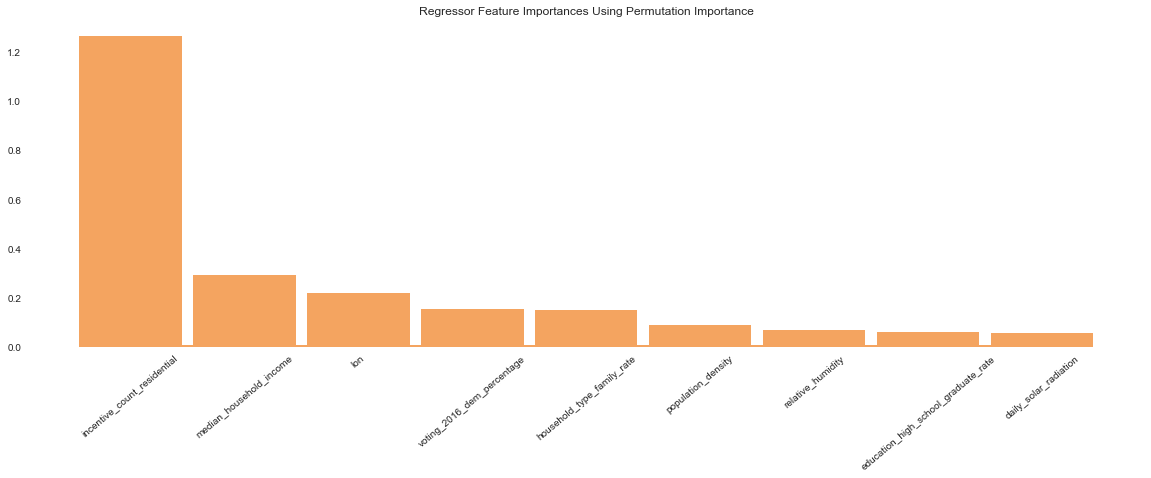

In [118]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values, color='sandybrown', width=.9)
ax.set_facecolor('white')
#ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importances Using Permutation Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names, rotation=40)
plt.axhline(0, xmin=.05, xmax=.95, color='sandybrown', linewidth=4)
plt.show()

## Feature Importances without cross-validation

The feature importances in this section were calculated on a dataset with a different outcome variable and before feature selection using linear regression with L1 regularization.

### Classifier Feature Importances

Permutation importances are expected to return more accurate feature importances due to its underlying calculations.  Standard sklearn feature importances are also calculated as a comparison

Classifier permutation importances for base dataset (see Data Set Up notebook)

In [50]:
feature_cols = deepsolar.drop(labels=["solar_flag", 'number_of_solar_system_per_household'], axis=1).columns.values

In [51]:
classifier_importances_permutation = rfp.importances(classifier, 
                                                     pd.DataFrame(X_dev,columns=feature_cols), 
                                                     pd.DataFrame(Y_classifier_dev,columns=['solar_flag']))

In [52]:
print("Classifier features importances by permutation importance\n")
print(classifier_importances_permutation[:20])

Classifier features importances by permutation importance

                                     Importance
Feature                                        
population_density                       0.0214
occupation_agriculture_rate              0.0062
heating_fuel_coal_coke_rate              0.0040
average_household_income                 0.0038
transportation_car_alone_rate            0.0038
travel_time_40_59_rate                   0.0038
travel_time_average                      0.0030
property_tax                             0.0030
lat                                      0.0030
education_high_school_graduate_rate      0.0028
lon                                      0.0028
incentive_residential_state_level        0.0028
age_75_84_rate                           0.0028
daily_solar_radiation                    0.0026
frost_days                               0.0026
education_professional_school_rate       0.0022
occupancy_vacant_rate                    0.0022
transportation_public_rate   

Classifier standard gini importances for base dataset

In [53]:
classifier_importances_standard=pd.DataFrame(classifier.feature_importances_, 
                                             index=feature_cols, 
                                             columns=["Importance"]) \
                                  .sort_values("Importance", ascending=False)

In [54]:
print("Classifier feature importances by sklearn's gini importance\n")
print(classifier_importances_standard[:20])

Classifier feature importances by sklearn's gini importance

                                Importance
population_density                0.064071
heating_fuel_coal_coke_rate       0.028027
occupancy_vacant_rate             0.021678
lon                               0.020007
housing_unit_median_value         0.019941
race_asian_rate                   0.019636
housing_unit_median_gross_rent    0.018014
mortgage_with_rate                0.017547
relative_humidity                 0.015892
education_bachelor_rate           0.015736
transportation_car_alone_rate     0.013150
travel_time_less_than_10_rate     0.013010
average_household_income          0.012693
race_white_rate                   0.012612
transportation_public_rate        0.012172
travel_time_10_19_rate            0.012062
number_of_years_of_education      0.011627
per_capita_income                 0.011597
education_master_rate             0.011419
daily_solar_radiation             0.011265


### Regressor Feature Importances

Regressor permutation importances for base dataset

In [55]:
regressor_importances_permutation = rfp.importances(regressor, 
                                                    pd.DataFrame(X_dev,columns=feature_cols), 
                                                    pd.DataFrame(Y_regressor_dev,
                                                                 columns=['number_of_solar_system_per_household']))

In [56]:
print("Regressor feature importances by permutation importance\n")
print(regressor_importances_permutation[:20])

Regressor feature importances by permutation importance

                                   Importance
Feature                                      
incentive_count_residential          1.130405
lon                                  0.277016
daily_solar_radiation                0.166695
occupancy_owner_rate                 0.147503
voting_2016_dem_percentage           0.087474
median_household_income              0.068278
population_density                   0.048287
household_type_family_rate           0.027957
lat                                  0.025149
relative_humidity                    0.020517
incentive_residential_state_level    0.020043
sales_tax                            0.015806
heating_fuel_coal_coke_rate          0.013972
housing_unit_median_gross_rent       0.013486
occupation_agriculture_rate          0.011507
housing_unit_median_value            0.009371
county                               0.007275
electricity_consume_residential      0.006794
wind_speed             

Regressor standard gini importances for base dataset

In [57]:
regressor_importances_standard=pd.DataFrame(regressor.feature_importances_, 
                                             index=feature_cols, 
                                             columns=["Importance"]) \
                                  .sort_values("Importance", ascending=False)

In [58]:
print("Regressor feature importances by sklearn's gini importance\n")
print(regressor_importances_standard[:20])

Regressor feature importances by sklearn's gini importance

                                   Importance
incentive_count_residential          0.172829
occupancy_owner_rate                 0.118718
daily_solar_radiation                0.090461
median_household_income              0.053300
lon                                  0.041521
population_density                   0.027376
education_college_rate               0.024851
housing_unit_median_gross_rent       0.021020
household_type_family_rate           0.019904
lat                                  0.019698
voting_2016_dem_percentage           0.019339
occupation_manufacturing_rate        0.012147
health_insurance_public_rate         0.011949
relative_humidity                    0.010825
heating_fuel_coal_coke_rate          0.010455
housing_unit_median_value            0.009732
health_insurance_none_rate           0.009612
mortgage_with_rate                   0.009577
sales_tax                            0.008904
incentive_residentia

Permutation importances from regressor for base dataset **with geographic features removed**

In [16]:
features_cols_nogeo = deepsolar.drop(labels=["solar_flag", 'number_of_solar_system_per_household'], axis=1) \
                               .columns.values

In [17]:
regressor_importances_permutation_no_geo = rfp.importances(regressor_nogeo, 
                                                           pd.DataFrame(X_dev,columns=features_cols_nogeo), 
                                                           pd.DataFrame(Y_regressor_dev,
                                                              columns=['number_of_solar_system_per_household']))

In [18]:
print("Regressor feature importances for dataset without geographic features by permutation importance\n")
print(regressor_importances_permutation_no_geo[:20])

Regressor feature importances for dataset without geographic features by permutation importance

                                   Importance
Feature                                      
incentive_count_residential          0.520552
daily_solar_radiation                0.153611
occupancy_owner_rate                 0.128958
population_density                   0.057664
median_household_income              0.055961
voting_2016_dem_percentage           0.053708
household_type_family_rate           0.032130
incentive_residential_state_level    0.026779
housing_unit_median_gross_rent       0.022259
sales_tax                            0.020740
relative_humidity                    0.019263
heating_fuel_coal_coke_rate          0.016197
electricity_consume_residential      0.013934
occupation_manufacturing_rate        0.013477
education_college_rate               0.008820
mortgage_with_rate                   0.008676
air_temperature                      0.008052
occupation_public_rate       

### Plots of Important Features

In [21]:
# choose number of features to show in each plot
feature_num = 9
feature_index = np.arange(feature_num)

First plot is from the base dataset 

In [44]:
# set up plot values
feature_values = regressor_importances_permutation[:feature_num]["Importance"]
feature_names = regressor_importances_permutation[:feature_num].index

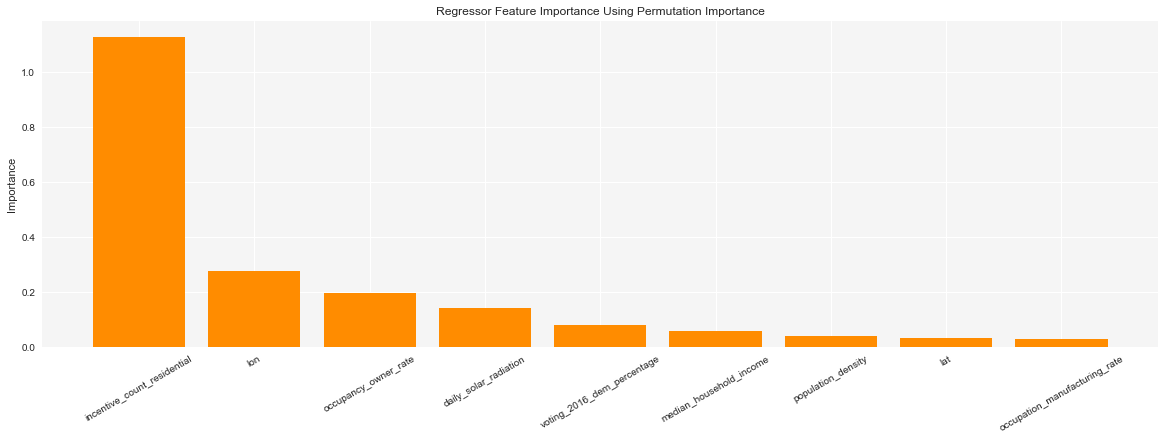

In [45]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Using Permutation Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names, rotation=30)
plt.show()

Second plot is from the dataset **without geographic features**

In [22]:
# set up plot values
feature_values_nogeo = regressor_importances_permutation_no_geo[:feature_num]["Importance"]
feature_names_nogeo = regressor_importances_permutation_no_geo[:feature_num].index

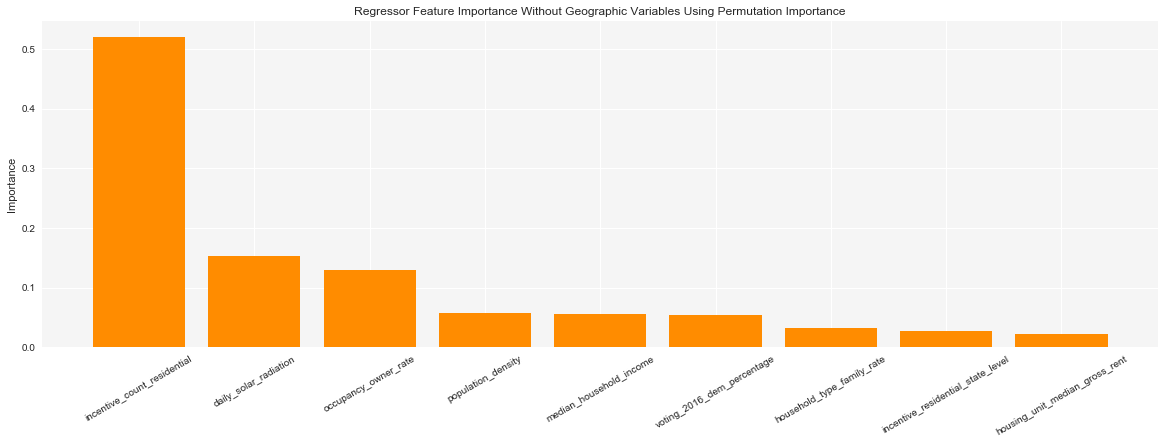

In [23]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values_nogeo, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Without Geographic Variables Using Permutation Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names_nogeo, rotation=30)
plt.show()

For comparison, the standard gini importances from the regressor on the base dataset

In [143]:
# set up plot values
feature_values_std = regressor_importances_standard[:feature_num]["Importance"]
feature_names_std = regressor_importances_standard[:feature_num].index

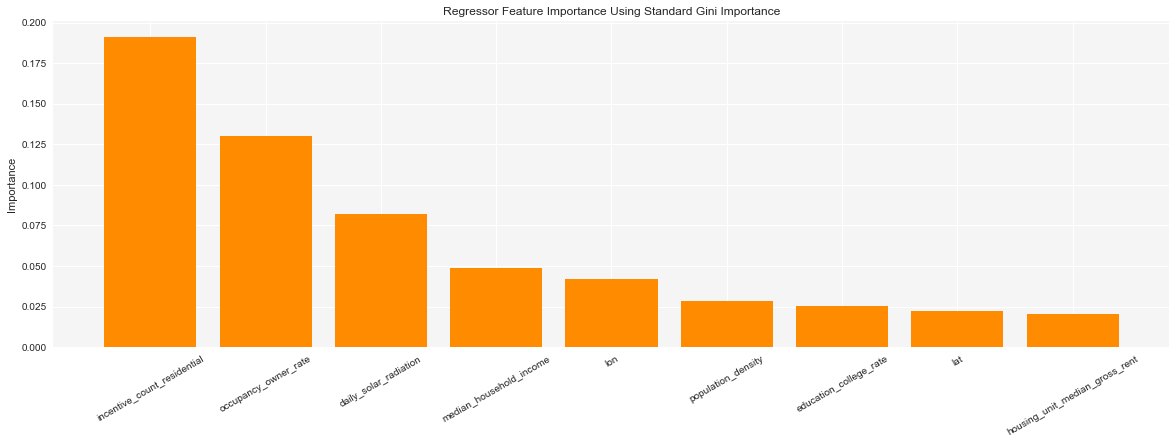

In [144]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values_std, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Using Standard Gini Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names_std, rotation=30)
plt.show()